importing the training dataset

In [ ]:
import pandas as pd

file_path = '230.csv'
data = pd.read_csv(file_path)
data.head()

,RESP,BP-S,BP-D,SpO2,HR,PULSE,Anomaly
0,15,54,73,97,72,71,0
1,15,54,73,97,72,71,0
2,15,54,73,97,72,71,0
3,15,54,73,97,72,71,0
4,15,55,74,97,72,71,0


PCA Test


        PC1       PC2  Anomaly
0 -1.325397  0.842222        0
1 -1.325397  0.842222        0
2 -1.325397  0.842222        0
3 -1.325397  0.842222        0
4 -1.220524  0.888928        0
         RESP      BP-S      BP-D      SpO2        HR     PULSE
PC1  0.331763  0.455541  0.462894 -0.276051  0.431450  0.453641
PC2  0.383034  0.205516  0.202745  0.869115 -0.096146 -0.073062


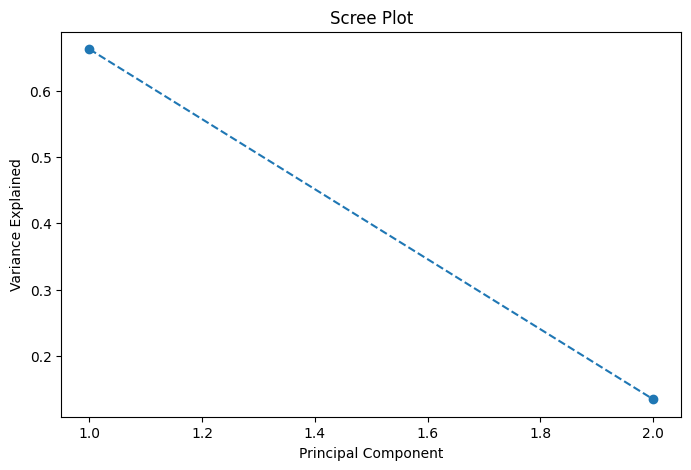

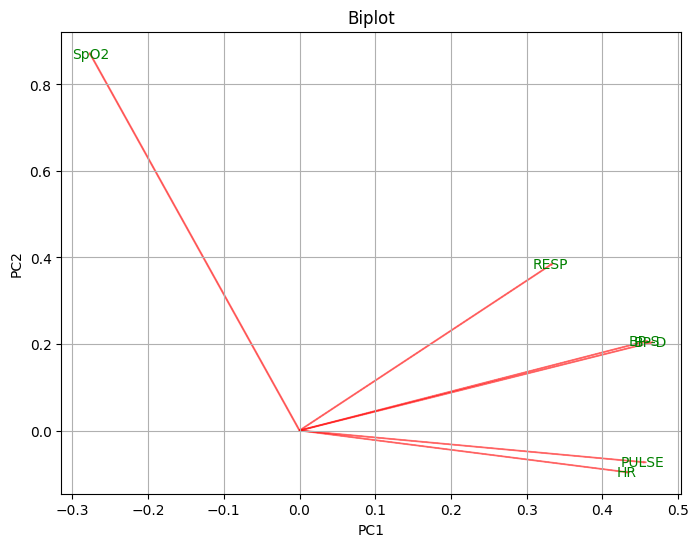

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = '230.csv'
data = pd.read_csv(file_path)

# Drop the 'Anomaly' column as it's categorical and not needed for PCA
features = data.drop(columns=['Anomaly'])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the 'Anomaly' column back to analyze the results
pca_df['Anomaly'] = data['Anomaly']

# Display the first few rows
print(pca_df.head())

# Get the PCA loadings (eigenvectors)
loadings = pd.DataFrame(pca.components_, columns=features.columns, index=['PC1', 'PC2'])
print(loadings)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 3), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

# Biplot
plt.figure(figsize=(8, 6))
for i, feature in enumerate(features.columns):
    plt.arrow(0, 0, loadings.loc['PC1', feature], loadings.loc['PC2', feature],
              color='r', alpha=0.5)
    plt.text(loadings.loc['PC1', feature], loadings.loc['PC2', feature], feature,
             color='g', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot')
plt.grid()
plt.show()

Heatmap

<Axes: >

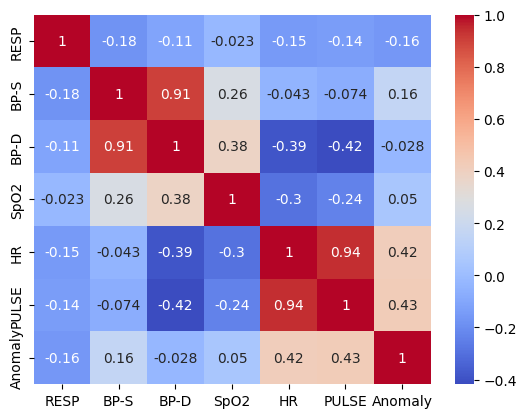

In [ ]:
import seaborn as sns

sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


Tier 1 assessment

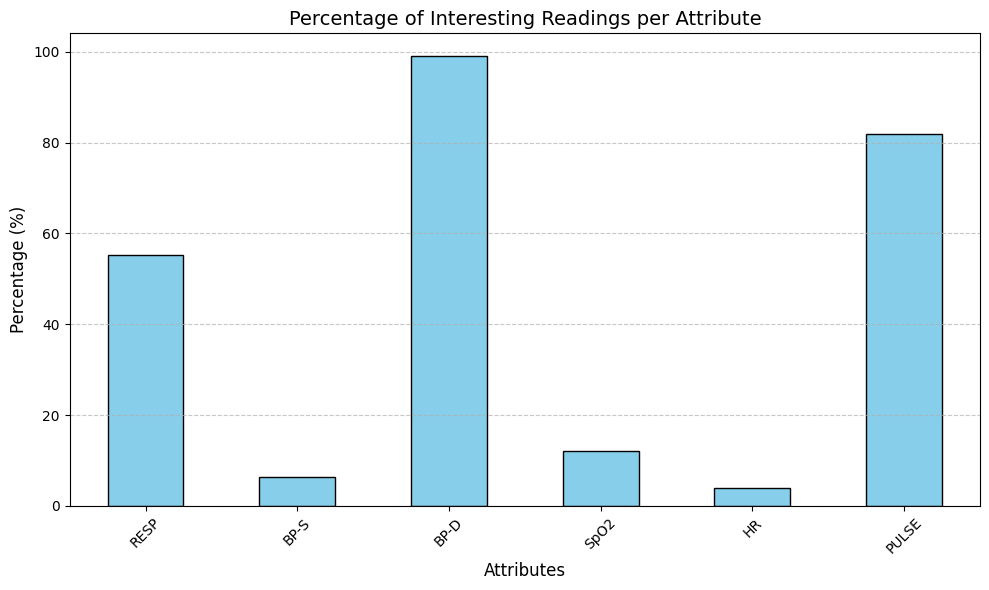

In [ ]:
import numpy as np

# Define thresholds and constants
lth = -3  # Lower threshold for Z-value
hth = 3   # Upper threshold for Z-value
epsilon = 0.15 # Threshold for ΔZ
Z_old = 0  # Initialize previous Z value

# Initialize mean (m), variance (v), and count (n)
mean_values = data.mean()
variance_values = data.var()
n = 1  # Start with 1 data point for initialization

# Function to calculate Z value
def calculate_Z(x, mean, variance):
    return (x - mean) / np.sqrt(variance) if variance > 0 else 0

# Tier-1 assessment implementation
results = []
mean_update = mean_values.copy()
variance_update = variance_values.copy()

for index, row in data.iterrows():
    processed_row = []
    for column in data.columns[:-1]:  # Exclude "Anomaly" column
        x_ijt = row[column]

        # Compute Z value
        Z_new = calculate_Z(x_ijt, mean_update[column], variance_update[column])

        # Check if Z_new is within thresholds
        if lth <= Z_new <= hth:
            delta_Z = abs(Z_new - Z_old)

            if delta_Z >= epsilon:  # Interesting point
                # Update mean and variance
                mean_update[column] = ((n - 1) * mean_update[column] + x_ijt) / n
                variance_update[column] = ((n - 1) / n) * (variance_update[column]+((mean_update[column] - x_ijt) ** 2)/n)
                processed_row.append(x_ijt)
            else:  # Uninteresting point
                processed_row.append(np.nan)  # Mark as uninteresting
        else:
            processed_row.append(None)  # Faulty point

        Z_old = Z_new  # Update Z_old

    results.append(processed_row)
    n += 1

# Convert results to a DataFrame
processed_data = pd.DataFrame(results, columns=data.columns[:-1])
processed_data["Anomaly"] = data["Anomaly"]
final_data = processed_data.dropna()

processed_data.head()
pd.DataFrame(processed_data).to_csv('tier1_result.csv', index=False)

import matplotlib.pyplot as plt

# Calculate the percentage of interesting readings for each column
total_readings = len(data)
interesting_readings = processed_data.notna().sum()[:-1]  # Exclude "Anomaly"
percent_interesting = (interesting_readings / total_readings) * 100

# Plot the percentages
plt.figure(figsize=(10, 6))
percent_interesting.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Percentage of Interesting Readings per Attribute", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xlabel("Attributes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Tier 2A : Generating Anomaly Score via CatBoost and LightGBM.
Also uses sliding window

In [ ]:
%pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Load CSV file
data = pd.read_csv('tier1_result.csv')

# Preprocessing: Fill missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data.iloc[:, :-1]), columns=data.columns[:-1])

# Parameters for sliding window and models
window_size = 1024  # Sliding window size
ntree = 100         # Number of estimators/trees

# Initialize sliding window and separate anomaly scores lists for each model
sliding_window = []
anomaly_scores_lgbm = []
anomaly_scores_catboost = []

# Function to calculate anomaly score using Euclidean distance
def calculate_anomaly_score(predicted, actual):
    return np.linalg.norm(predicted - actual, axis=1)

# Sliding window and anomaly detection loop
for i in range(len(data_imputed)):
    # Add data point to the sliding window
    sliding_window.append(data_imputed.iloc[i].values)

    # Check if the window is full
    if len(sliding_window) == window_size:
        # Convert sliding window to a numpy array
        window_data = np.array(sliding_window)

        # Split into features (X) and target (y)
        X_train = window_data[:, :-1]  # Use all columns except the last as features
        y_train = window_data[:, -1]   # Use the last column as the target variable

        # Train LightGBM model
        lgbm_model = LGBMRegressor(n_estimators=ntree, random_state=42)
        lgbm_model.fit(X_train, y_train)
        lgbm_predictions = lgbm_model.predict(X_train)

        # Train CatBoost model
        catboost_model = CatBoostRegressor(iterations=ntree, silent=True, random_seed=42)
        catboost_model.fit(X_train, y_train)
        catboost_predictions = catboost_model.predict(X_train)

        # Calculate anomaly scores for the window data for each model
        lgbm_scores = calculate_anomaly_score(lgbm_predictions.reshape(-1, 1), y_train.reshape(-1, 1))
        catboost_scores = calculate_anomaly_score(catboost_predictions.reshape(-1, 1), y_train.reshape(-1, 1))

        # Extend anomaly scores lists
        anomaly_scores_lgbm.extend(lgbm_scores)
        anomaly_scores_catboost.extend(catboost_scores)

        # Slide the window: reset the window list
        sliding_window = []

# Handle remaining data in the sliding window (if any)
if sliding_window:
    window_data = np.array(sliding_window)
    X_train = window_data[:, :-1]
    y_train = window_data[:, -1]

    # Train LightGBM model
    lgbm_model = LGBMRegressor(n_estimators=ntree, random_state=42)
    lgbm_model.fit(X_train, y_train)
    lgbm_predictions = lgbm_model.predict(X_train)

    # Train CatBoost model
    catboost_model = CatBoostRegressor(iterations=ntree, silent=True, random_seed=42)
    catboost_model.fit(X_train, y_train)
    catboost_predictions = catboost_model.predict(X_train)

    # Calculate anomaly scores for the remaining data for each model
    lgbm_scores = calculate_anomaly_score(lgbm_predictions.reshape(-1, 1), y_train.reshape(-1, 1))
    catboost_scores = calculate_anomaly_score(catboost_predictions.reshape(-1, 1), y_train.reshape(-1, 1))

    anomaly_scores_lgbm.extend(lgbm_scores)
    anomaly_scores_catboost.extend(catboost_scores)

# Merge the anomaly scores with the original data and ensure the lengths match
data_lgbm = data.copy()
data_catboost = data.copy()
data_lgbm['Anomaly_Score'] = anomaly_scores_lgbm[:len(data)]
data_catboost['Anomaly_Score'] = anomaly_scores_catboost[:len(data)]

data_lgbm.to_csv('anomaly_detected_lgbm.csv', index=False)
data_catboost.to_csv('anomaly_detected_catboost.csv', index=False)

print("Anomaly detection completed and results saved to 'anomaly_detected_lgbm.csv' and 'anomaly_detected_catboost.csv'.")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 5
[LightGBM] [Info] Start training from score 75.161116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 3
[LightGBM] [Info] Start training from score 76.792936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 0
[LightGBM] [Info] Start training from score 78.645839
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 3
[LightGBM] [Info] Start training from score 76.851860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 1
[LightGBM] [Info] Start training from score 83.533253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 1
[LightGBM] [Info] Start training from score 83.668086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 1
[LightGBM] [Info] Start training from score 84.336600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 4
[LightGBM] [Info] Start training from score 83.569437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 3
[LightGBM] [Info] Start training from score 87.488001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 4
[LightGBM] [Info] Start training from score 87.048117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 2
[LightGBM] [Info] Start training from score 92.168366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Tier 2B : Classifying anomaly : Approach 1- Random Forest


Random Forest Classifier Results:
Accuracy: 0.9714
Precision: 0.8378
Recall: 0.1845
F1 Score: 0.3024
ROC AUC: 0.9573
Confusion Matrix:
[[4826    6]
 [ 137   31]]


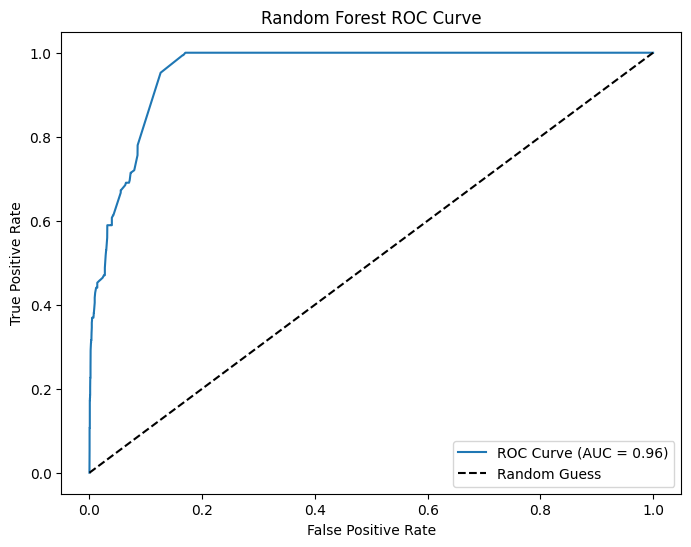

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)

# Load the dataset (dropping rows missing anomaly score or label)
df = pd.read_csv('anomaly_detected_lgbm_no_impute.csv').dropna(subset=['Anomaly_Score', 'Anomaly'])

# Use the anomaly score as the sole feature and 'Anomaly' as the target
X = df[['Anomaly_Score']]
y = df['Anomaly']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict on the testing set and obtain prediction probabilities
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("Random Forest Classifier Results:")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Confusion Matrix:")
print(cm)

# Compute ROC curve and plot it
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend()
plt.show()


Option 2: GridSearchCV optimisation

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best Parameters:
{'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest Classifier Results:
Accuracy: 0.9958
Precision: 0.9304
Recall: 0.9363
F1 Score: 0.9333
ROC AUC: 0.9796

Confusion Matrix:
[[4832   11]
 [  10  147]]


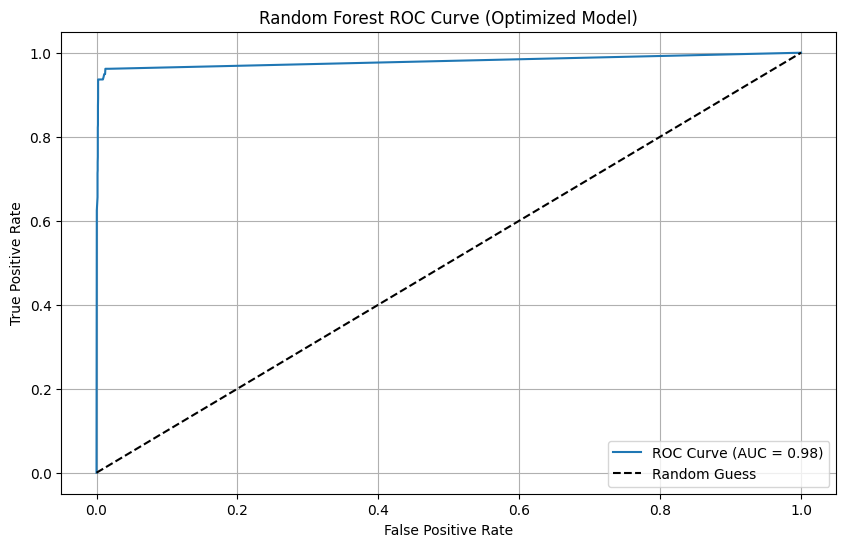


Feature Importance:
                 feature  importance
1  Anomaly_Score_Squared    0.386389
0          Anomaly_Score    0.383095
2    Anomaly_Score_Cubed    0.230515


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)
from sklearn.preprocessing import StandardScaler

# Load and prepare the dataset (only rows with valid Anomaly_Score and Anomaly are used)
df = pd.read_csv('anomaly_detected_lgbm_no_impute.csv').dropna(subset=['Anomaly_Score', 'Anomaly'])

# Feature engineering: add squared and cubed terms of Anomaly_Score
X = pd.DataFrame({
    'Anomaly_Score': df['Anomaly_Score'],
    'Anomaly_Score_Squared': df['Anomaly_Score'] ** 2,
    'Anomaly_Score_Cubed': df['Anomaly_Score'] ** 3
})
y = df['Anomaly']

# Split the dataset (using stratification to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a reduced parameter grid to limit computation time
param_grid_optimized = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt']  # restricting to one method speeds up search
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with 3-fold CV to reduce runtime
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_optimized,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best model from grid search
best_rf = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test_scaled)
y_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

# Calculate performance metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob)
}

print("\nBest Parameters:")
print(grid_search.best_params_)

print("\nRandom Forest Classifier Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot ROC curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {metrics['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (Optimized Model)')
plt.legend()
plt.grid(True)
plt.show()

# Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Using RandomSearchCV

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 264}

Random Forest Classifier Results:
Accuracy: 0.9928
Precision: 0.8497
Recall: 0.9363
F1 Score: 0.8909
ROC AUC: 0.9847

Confusion Matrix:
[[4817   26]
 [  10  147]]


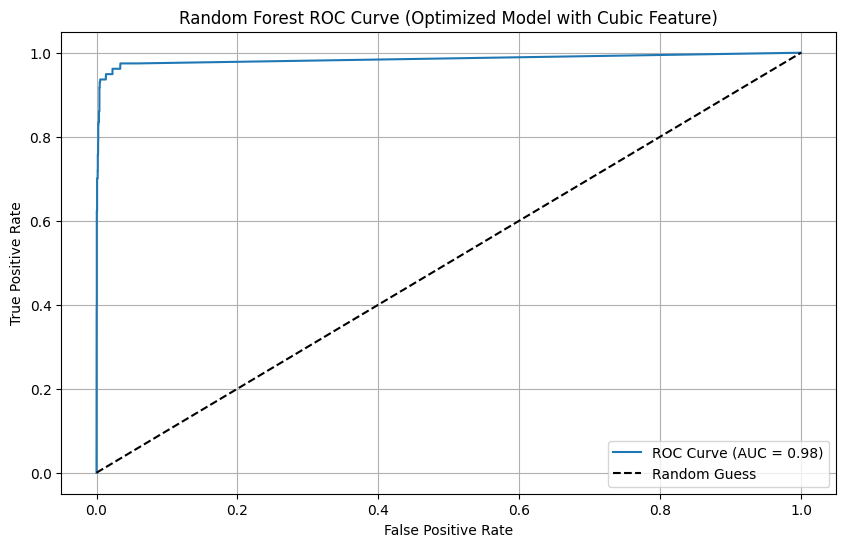


Feature Importance:
                 feature  importance
1  Anomaly_Score_Squared    0.386387
0          Anomaly_Score    0.360595
2    Anomaly_Score_Cubic    0.253018


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

# Load and prepare the dataset
df = pd.read_csv('anomaly_detected_lgbm_no_impute.csv').dropna(subset=['Anomaly_Score', 'Anomaly'])

# Feature engineering: Add squared and cubic terms of Anomaly_Score
X = pd.DataFrame({
    'Anomaly_Score': df['Anomaly_Score'],
    'Anomaly_Score_Squared': df['Anomaly_Score'] ** 2,
    'Anomaly_Score_Cubic': df['Anomaly_Score'] ** 3
})
y = df['Anomaly']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(5, 20, 5)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2']
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    cv=3,       # Using 3-fold CV for faster execution
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Get best model
best_rf = random_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test_scaled)
y_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_prob)
}

# Print results
print("\nBest Parameters:", random_search.best_params_)
print("\nRandom Forest Classifier Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot ROC curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {metrics['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (Optimized Model with Cubic Feature)')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

new scoring metric (mad + z score)

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor

# Load CSV
data = pd.read_csv('tier1_result.csv')

# No imputation: Use raw data (keep NaNs)
data_raw = data.iloc[:, :-1]
target = data.iloc[:, -1]

# Parameters
window_size = 1024
ntree = 100

sliding_window = []
anomaly_scores_lgbm = []

# MAE-based scoring function
def calculate_mae_score(predicted, actual):
    return np.abs(predicted - actual)

# Sliding window loop
for i in range(len(data_raw)):
    current_row = data_raw.iloc[i].values
    target_val = target.iloc[i]

    sliding_window.append(np.append(current_row, target_val))

    if len(sliding_window) == window_size:
        window_data = np.array(sliding_window)
        X_train = window_data[:, :-1]
        y_train = window_data[:, -1]

        # Train LightGBM with native missing support
        model = LGBMRegressor(n_estimators=ntree, random_state=42)
        model.fit(X_train, y_train)

        predictions = model.predict(X_train)

        scores = calculate_mae_score(predictions, y_train)
        anomaly_scores_lgbm.extend(scores)

        sliding_window = []

# Handle remaining rows
if sliding_window:
    window_data = np.array(sliding_window)
    X_train = window_data[:, :-1]
    y_train = window_data[:, -1]

    model = LGBMRegressor(n_estimators=ntree, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_train)

    scores = calculate_mae_score(predictions, y_train)
    anomaly_scores_lgbm.extend(scores)

# Output
data_output = data.copy()
data_output['Anomaly_Score'] = anomaly_scores_lgbm[:len(data)]
data_output.to_csv('anomaly_detected_lgbm_no_impute.csv', index=False)

print("Anomaly detection complete. Results saved to 'anomaly_detected_lgbm_no_impute.csv'.")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 5
[LightGBM] [Info] Start training from score 0.268555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training b